In [1]:
using DataFrames, CSV, Random, LowRankModels, LinearAlgebra, Statistics, Plots
include("proxgrad.jl")

proxgrad_const

In [2]:
players_df = CSV.read("data/consolidated_players_dataset.csv")

,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24,2P,2P%,2PA
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,30431854,37800000,40824000,43848000,46872000,0,5.4,0.53,10.1
2,6041520,7059480,8930242,0,0,0,4.3,0.46,9.3
3,1544951,2305057,0,0,0,0,0.7,0.47,1.5
4,13045455,11954546,10863637,0,0,0,1.6,0.52,3.1
5,1740000,2033160,3665787,0,0,0,0.9,0.47,1.9
6,3000000,0,0,0,0,0,4.7,0.52,9.12
7,16539326,17617977,0,0,0,0,4.7,0.59,8.0
8,327566,0,0,0,0,0,1.0,0.56,1.8
9,14681317,0,0,0,0,0,2.4,0.52,4.6


In [3]:
# computes mean squared error
function MSE(y, pred)
    MSE = mean((y - pred).^2)
end

MSE (generic function with 1 method)

In [4]:
"""This completed function plots the main diagonal; 
for a "predicted vs true" plot with perfect predictions,
all data lies on this line"""
function plotDiagonal(xmin, xmax)
    xsamples = [xmin, xmax]
    plot!(xsamples, xsamples, color=:black)
end

plotDiagonal

In [5]:
"""This completed helper funciton plots x vs, y and labels the axes."""
function plotdata(x,y,xname, yname; margin=.05, plotDiag=true, zeromin=false)
    scatter(x,y, label="data")
    xlabel!(xname)
    ylabel!(yname)
    range_y = maximum(y) - minimum(y)
    range_x = maximum(x) - minimum(x)
    if plotDiag
        plotDiagonal(minimum(x)-margin*range_x, maximum(x)+margin*range_x)
    end
    if zeromin
        ylims!((0.0,maximum(y)+margin*range_y))
        xlims!((0.0,maximum(x)+margin*range_x))
    else
        ylims!((minimum(y)-margin*range_y,maximum(y)+margin*range_y))
        xlims!((minimum(x)-margin*range_x,maximum(x)+margin*range_x))
    end
end

"""This completed function plots the predicted labels vs the actual labels
(We only plots the first 1000 points to avoid slow plots.)"""
function plot_pred_true(test_pred, test_y, max_points = 125)
    plotdata(test_pred[1:max_points], test_y[1:max_points], "Predicted (\$)", "True (\$)", zeromin=true)
end

plot_pred_true

Since the quadratic loss function is sensitive to outliers, we expect that using this loss function will largely be ineffective in the context of our dataset, given the myriad of situations in which outlier contracts are given. (For example, elite-performing players may still receive disproportionately low contracts in the case of an injury; and at the other extreme, seemingly poor-performing players may still receive disproportionately high contracts due to NBA front offices recognizing their potential to improve in the imminent future.) Nevertheless, we still confirm this is indeed the case by developing a model featuring quadratic loss and quadratic regularization.

In [6]:
num_examples = size(players_df)[1]

415

In [7]:
# used to help "shuffle" dataset so that we can 
# randomly split dataset into training set and test set
shuffled_indices = shuffle(1:num_examples)

415-element Array{Int64,1}:
 294
  72
 232
 235
 338
 189
 357
 382
 350
 234
 406
 239
  53
   ⋮
 227
 183
  39
 151
 321
 228
 391
  43
 295
 310
 206
 292

Using the randomly shuffled indices from above, we split the dataset into training and test sets:

In [8]:
training_set = players_df[shuffled_indices[1:Int64(ceil(num_examples/2))],:]

,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24,2P,2P%,2PA
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1378242,0,0,0,0,0,1.7,0.61,2.8
2,25434263,27093019,28751775,0,0,0,6.0,0.54,11.2
3,13565218,0,0,0,0,0,3.5,0.51,6.8
4,11536515,0,0,0,0,0,1.9,0.44,4.3
5,11286516,3000000,0,0,0,0,0.5,0.42,1.19
6,7200000,0,0,0,0,0,3.2,0.59,5.4
7,5250000,0,0,0,0,0,2.3,0.56,4.1
8,1621415,1845301,0,0,0,0,1.81,0.56,3.21
9,2516048,0,0,0,0,0,1.4,0.54,2.6


In [9]:
test_set = players_df[shuffled_indices[Int64(ceil(num_examples/2)) + 1:end],:]

,2018-19,2019-20,2020-21,2021-22,2022-23,2023-24,2P,2P%,2PA
,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,2807880,3280920,5029650,0,0,0,1.9,0.56,3.4
2,7461960,8719320,11003782,0,0,0,2.2,0.42,5.2
3,20000000,20000000,0,0,0,0,4.2,0.52,8.1
4,1544951,0,0,0,0,0,0.9,0.43,2.1
5,1667160,1948080,3516284,0,0,0,0.5,0.42,1.2
6,2165481,0,0,0,0,0,0.5,0.42,1.2
7,1378242,1618520,0,0,0,0,1.2,0.43,2.8
8,15627467,5100000,0,0,0,0,3.2,0.48,6.6
9,2176260,0,0,0,0,0,2.1,0.6,3.5


In [10]:
num_training_examples = size(training_set)[1]
X_train = convert(Matrix, training_set[:,["PTS", "TRB", "AST", "STL", "BLK", "eFG%"]])
y_train = training_set[:,"Guaranteed"]
Xoffset_train = [X_train ones(length(y_train))]

208×7 Array{Float64,2}:
  5.3    4.3   0.9   0.5   0.8   0.58  1.0
 15.0   16.0   3.0   1.5   1.6   0.53  1.0
  8.4    7.6   1.8   0.5   0.7   0.51  1.0
  7.7    3.0   1.0   0.6   0.1   0.47  1.0
  1.22   2.59  0.17  0.12  0.19  0.42  1.0
 10.0    7.9   1.5   0.6   0.8   0.57  1.0
  8.2    4.3   0.9   1.4   0.3   0.56  1.0
  7.11   3.1   0.99  0.68  0.28  0.54  1.0
  6.2    2.5   0.7   0.4   0.2   0.52  1.0
  3.42   1.3   0.49  0.39  0.0   0.42  1.0
  7.9    2.5   2.8   0.7   0.2   0.42  1.0
 22.6    4.4   4.5   1.2   0.4   0.52  1.0
 13.9    6.8   2.5   1.0   0.7   0.48  1.0
  ⋮                              ⋮     
  1.0    1.0   0.3   0.2   0.0   0.33  1.0
 11.8    4.5   1.9   0.2   0.8   0.53  1.0
  1.7    2.0   0.6   0.3   0.3   0.5   1.0
 17.2    8.1   4.2   0.7   1.4   0.47  1.0
 18.0    0.0   4.0   0.0   0.0   0.46  1.0
  1.1    0.79  0.59  0.3   0.09  0.42  1.0
  2.0    0.0   0.0   1.0   0.0   0.5   1.0
  9.69   3.43  1.22  0.82  0.27  0.49  1.0
  5.5    1.9   2.0   0.5   0.3   

In [11]:
num_test_examples = size(test_set)[1]
X_test = convert(Matrix, test_set[:,["PTS", "TRB", "AST", "STL", "BLK", "eFG%"]])
y_test = test_set[:,"Guaranteed"]
Xoffset_test = [X_test ones(length(y_test))]

207×7 Array{Float64,2}:
  6.7  2.8  1.1  0.4  0.2  0.5   1.0
 10.2  6.9  7.2  1.7  0.8  0.44  1.0
 12.6  4.9  1.9  0.8  0.3  0.53  1.0
  5.8  1.4  1.0  0.2  0.1  0.47  1.0
  3.2  1.5  0.5  0.2  0.2  0.61  1.0
  2.0  1.1  0.4  0.3  0.1  0.31  1.0
  3.3  2.4  0.7  0.3  0.0  0.42  1.0
 10.1  8.1  3.1  0.3  1.0  0.49  1.0
  5.7  3.8  1.0  0.3  0.4  0.62  1.0
  7.9  2.5  1.9  0.5  0.3  0.57  1.0
  3.3  0.7  2.3  1.0  0.0  0.65  1.0
  4.7  1.5  0.4  0.5  0.1  0.53  1.0
 12.2  7.2  1.2  0.8  0.7  0.58  1.0
  ⋮                        ⋮     
  5.4  3.3  0.7  0.4  0.7  0.56  1.0
  5.4  1.1  0.7  0.3  0.1  0.77  1.0
  3.9  2.4  0.7  0.6  0.3  0.53  1.0
 11.3  4.7  2.9  1.0  0.2  0.5   1.0
 13.5  3.9  1.9  1.1  0.3  0.54  1.0
  6.9  1.4  1.0  0.4  0.0  0.51  1.0
 14.5  4.9  1.6  1.0  0.4  0.53  1.0
  4.8  1.8  2.1  0.8  0.1  0.39  1.0
  3.7  2.2  0.9  0.5  0.2  0.44  1.0
  4.6  2.6  2.2  0.8  0.4  0.37  1.0
 16.7  3.7  3.4  1.0  0.3  0.53  1.0
  6.5  4.4  1.6  0.3  0.6  0.51  1.0

Having created our training and test sets, we now run the proximal gradient method on our training set to find minimizer $w$:

In [12]:
# we form \frac 1 n || ⋅ ||^2 by multiplying the QuadLoss() function by 1/n
loss = 1/num_training_examples*QuadLoss()

λ = .1
reg = λ*QuadReg()

# minimize 1/n ||Xw - y||^2 + λ||w||^2
w = proxgrad(loss, reg, X_train, y_train, maxiters=5)

6-element Array{Float64,1}:
      2.064261966045676e6
 448821.13798926136
 784080.9897711393
 138188.29996325367
   3723.6793669924405
   1902.6779922296364

From here, we can compute the mean squared error for both the training and test models:

In [13]:
train_preds = X_train * w
test_preds = X_test * w

train_MSE = MSE(y_train, train_preds)
test_MSE = MSE(y_test, test_preds)

println("Train MSE\t", train_MSE)
println("Test MSE \t", test_MSE)

Train MSE	6.818237201151075e14
Test MSE 	4.583181702136636e14


As expected, using quadratic loss with quadratic regularization falls significantly short of fitting our data well, with both the training and test mean squared errors reaching alarmingly high levels. Upon visualizing this below, we notice that outliers in particular helped derail the accuracy of this model, again affirming our aforementioned suspicion that quadratic loss would be too sensitive to outlier contracts received by NBA players:

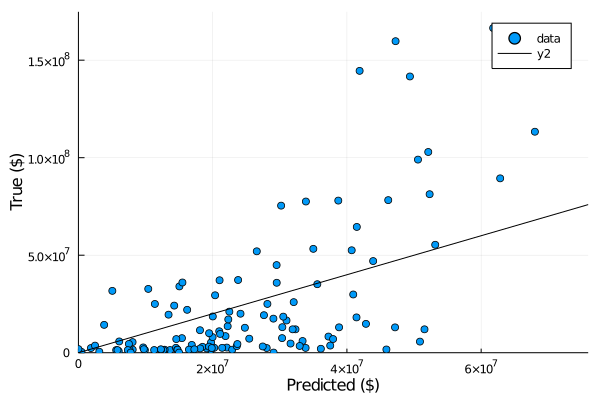

In [14]:
plot_pred_true(train_preds, y_train)

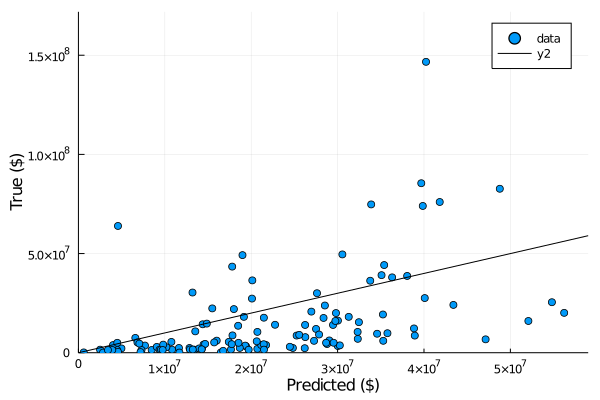

In [15]:
plot_pred_true(test_preds, y_test)